In [ ]:
# import matplotlib, mplcairo
# print('Default backend: ' + matplotlib.get_backend())
# matplotlib.use("module://mplcairo.macosx")
# print('Backend is now ' + matplotlib.get_backend())

# IMPORTANT: Import these libraries only AFTER setting the backend
# import matplotlib.pyplot as plt, numpy as np
# from matplotlib.font_manager import FontProperties

# Load Apple Color Emoji font
# prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')
%matplotlib inline
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import os
import s2sphere as s2
import json
import pandas as pd
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/Users/atharvas/Documents/FALL_2020/LING506/repo/BG"

In [1]:
def get_s2cell(lat, long, level):
    generator_obj = s2.CellId().from_lat_lng(s2.LatLng.from_degrees(lat, long)).parent(level)
    token = generator_obj.to_token()
    lat = generator_obj.to_lat_lng().lat().degrees
    lng = generator_obj.to_lat_lng().lng().degrees
    return (token, lat, lng)
get_s2cells = lambda df: pd.DataFrame(df.apply(lambda row: get_s2cell(row['lat_x'], row['lon_x'], 14), axis=1).tolist(), columns=['token', 'slat', 'slng'])


In [2]:
all_tweets = pd.read_pickle("../data/cleanmoji.pkl")#.head(10000)
all_tweets['created_at_date'] = pd.to_datetime(all_tweets['created_at'], infer_datetime_format=True) 
all_tweets = all_tweets.merge(get_s2cells(all_tweets), left_index=True, right_index=True)
all_tweets.set_index('created_at_date', inplace=True)
plot = all_tweets.resample('1H').mean()[['slat', 'slng', 'Sent_1']]

us_tweets = all_tweets[all_tweets['cc'] == "US"]
all_tweets['cc'].unique(), all_tweets.columns



NameError: name 'pd' is not defined

NameError: name 'prop' is not defined

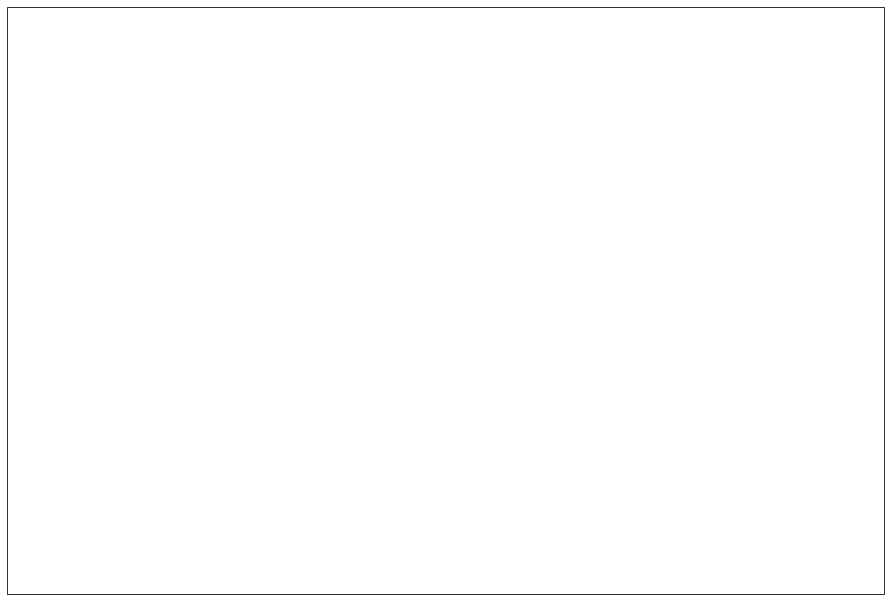

In [209]:
fig = plt.figure(figsize=(9.6*2, 5.4*2))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-60,  
                                       min_latitude=-30,
                                       max_latitude=60))
# ax.background_img(name='BM', resolution='low')

# ax.set_extent([-150, 30, -30, 60], crs=ccrs.PlateCarree())
# ax.scatter(tweets['slng'], tweets['slat'], s=tweets['Emoji_1'].map(counts), , alpha=0.8, transform=ccrs.PlateCarree())

# fig.tight_layout(pad=-0.5)


def emoji_scatter(x_array, y_array, emoji_array, size_array, ax, fig):
    ax.scatter(x_array, y_array, color="white", transform=ccrs.PlateCarree())

    #annotate with your emojis
    for i, txt in enumerate(emoji_array):
        ax.annotate(txt, (x_array[i], y_array[i]),
        ha="center",
        va="bottom",
        fontsize=size_array[i],
        fontproperties=prop)

    if savename:
        fig.savefig(savename)

    return ax, fig

ax, fig = emoji_scatter(tweets['slng'], tweets['slat'], tweets['Emoji_1'], tweets['Emoji_1'].map(counts), ax, fig)




In [208]:
# counts = pd.melt(tweets[[f'Emoji_{i+1}' for i in range(5)]])['value'].value_counts()



#..value_counts().to_dict()

created_at_date
2012-10-25 19:18:02+00:00    12
2012-10-25 19:18:42+00:00    18
2012-10-25 19:18:46+00:00     2
2012-10-25 19:19:06+00:00    18
2012-10-25 19:19:36+00:00     8
                             ..
2012-10-25 19:54:22+00:00     9
2012-10-25 19:56:11+00:00    10
2012-10-25 19:57:27+00:00     7
2012-10-25 19:58:46+00:00    11
2012-10-25 19:59:24+00:00    18
Name: Emoji_1, Length: 62, dtype: int64

In [172]:
for i, d in enumerate(plot.index):
    if i == len(plot.index) - 1:
        break
    n = plot.index[i+1] 
    tweets = all_tweets[(all_tweets.index < n) & (d <= all_tweets.index)]
    count = tweets.shape[0]
    maxmoji = tweets[[f'Emoji_{i+1}' for i in range(5)]].values.flatten().max() if count > 0 else '❌'
    print(d.strftime("%d %b %H:%M %p"), maxmoji, count)
    break
#     ax.scatter(tweets['slng'], tweets['slat'], s=1, alpha=0.8, transform=ccrs.PlateCarree())


25 Oct 19:00 PM 🙏 62


In [162]:
# ny_tweets = all_tweets[(all_tweets['admin1'] == 'New Jersey') | (all_tweets['admin1'] == 'New York')]
# for i, d in enumerate(plot.index):
#     if i == len(plot.index) - 1:
#         break
#     n = plot.index[i+1] 
#     tweets = ny_tweets[(ny_tweets.index < n) & (d <= ny_tweets.index)]
#     ntweets = tweets.shape[0]
#     maxmoji = tweets[[f'Emoji_{i+1}' for i in range(1)]].values.flatten().max() if ntweets > 0 else '❌'
#     count = tweets[[f'Emoji_{i+1}' for i in range(1)]].values.flatten().argmax() if ntweets > 0 else 0
#     perc = round(100 * count / ntweets, 3)if ntweets > 0 else 0
#     print(d.strftime("%d %b %H:%M %p"), maxmoji, perc)
# #     ax.scatter(tweets['slng'], tweets['slat'], s=1, alpha=0.8, transform=ccrs.PlateCarree())


In [19]:
a = {'❌': 10, '❌': 23, '❌': 13, '❌': 10, '❌': 13}

In [22]:
import matplotlib.pyplot as plt, numpy as np
from matplotlib.font_manager import FontProperties

# Load Apple Color Emoji font 
wplt.rcParams['font.family'] = prop.get_family()

# Set up plot
freqs = [301, 96, 53, 81, 42]
labels = ['😊', '😱', '😂', '😄', '😛']
plt.figure(figsize=(12,8))
p1 = plt.bar(np.arange(len(labels)), freqs, 0.8, color="lightblue")
plt.ylim(0, plt.ylim()[1]+30)

# Make labels
for rect1, label in zip(p1, labels):
    height = rect1.get_height()
    plt.annotate(
        label,
        (rect1.get_x() + rect1.get_width()/2, height+5),
        ha="center",
        va="bottom",
        fontsize=30,
        fontproperties=prop
    )
    
plt.show()

RuntimeError: In FT2Font: Could not set the fontsize

<Figure size 864x576 with 1 Axes>

In [1]:
a

NameError: name 'a' is not defined